## 1. Modelado y cuadrados mínimos

En esta sección comenzamos ajustando un modelo cuadrático a un conjunto reducido de datos.
Formulamos la matriz de diseño, planteamos las ecuaciones normales y resolvemos el sistema
numéricamente para obtener los coeficientes del modelo.

## a) Construcción de la matriz de diseño

Primero organizamos los datos y armamos la matriz de diseño correspondiente al modelo cuadrático:

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2.
$$

## b) Crear una función en Python que resuelva el sistema

En este inciso implementamos una función para resolver el sistema normal:

$$
A^T A\,\beta = A^T y.
$$

La resolución se realiza mediante eliminación gaussiana con pivoteo parcial.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
def gaussian_elimination_solve(M, b):
    M = M.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)
    for k in range(n - 1):
        p = k + np.argmax(np.abs(M[k:, k]))
        if np.isclose(M[p, k], 0.0):
            raise ValueError("Matriz singular o mal condicionada.")
        if p != k:
            M[[k, p]] = M[[p, k]]
            b[[k, p]] = b[[p, k]]
        for i in range(k + 1, n):
            m = M[i, k] / M[k, k]
            M[i, k:] -= m * M[k, k:]
            b[i]     -= m * b[k]
    z = np.zeros(n)
    for i in range(n - 1, -1, -1):
        z[i] = (b[i] - np.dot(M[i, i + 1:], z[i + 1:])) / M[i, i]
    return z


## c) Graficar los datos y la curva ajustada

A partir de los coeficientes obtenidos, la curva ajustada se define como:

$$
\hat{y}(x) = \beta_0 + \beta_1 x + \beta_2 x^2.
$$

Luego se grafican los puntos originales y la curva estimada para visualizar el ajuste obtenido.

Coeficientes del modelo: [ 1.03142857  0.91714286 -0.01428571]


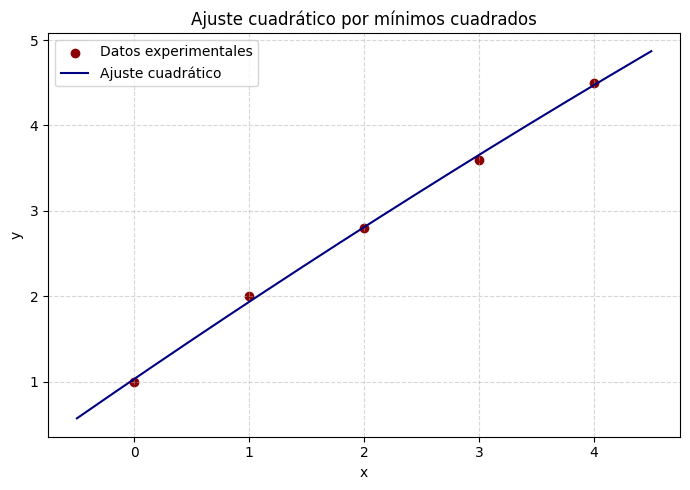

In [54]:

x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)


A = np.vstack([np.ones_like(x), x, x**2]).T
ATA = A.T @ A
ATy = A.T @ y


beta = gaussian_elimination_solve(ATA, ATy)
b0, b1, b2 = beta
print("Coeficientes del modelo:", beta)

xx = np.linspace(x.min()-0.5, x.max()+0.5, 200)
yy = b0 + b1*xx + b2*xx**2


plt.figure(figsize=(7,5))
plt.scatter(x, y, color='darkred', label='Datos experimentales')
plt.plot(xx, yy, color='navy', label='Ajuste cuadrático')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ajuste cuadrático por mínimos cuadrados")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## d) Error cuadrático medio (MSE)

Evaluamos la calidad del ajuste calculando el error cuadrático medio:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat y_i)^2.
$$

In [55]:

y_hat = A @ beta
mse = np.mean((y - y_hat) ** 2)

print("MSE =", mse)
print("MSE (8 decimales) =", f"{mse:.8f}")

MSE = 0.0018285714285714183
MSE (8 decimales) = 0.00182857


## 2. Interpretación mediante SVD

En esta sección analizamos la matriz de diseño utilizando su descomposición en valores singulares (SVD),
lo que permite estudiar el condicionamiento del problema y verificar la equivalencia con la solución de
ecuaciones normales.




In [56]:
x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)
A = np.vstack([np.ones_like(x), x, x**2]).T
A

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.]])

## a) Calcular la SVD de la matriz de diseño

Calculamos la descomposición:

$$
A = U \Sigma V^T,
$$

y examinamos los valores singulares para estudiar la estructura del problema.

In [57]:


# Matriz A^T A
ATA = A.T @ A

# Autovalores y autovectores de A^T A
lambdas, V_eig = np.linalg.eig(ATA)

# Valores singulares obtenidos como sqrt(autovalores)
sigmas_from_lambdas = np.sqrt(lambdas)

print("Autovalores de A^T A:")
print(lambdas)
print("\nSigmas = sqrt(autovalores):")
print(sigmas_from_lambdas)

# SVD directa de A
U, S, Vt = np.linalg.svd(A, full_matrices=False)
print("\nValores singulares S (SVD):")
print(S)

# Comparación entre sigmas de SVD y sqrt(λ)
print("\nDiferencia entre sigmas (SVD) y sqrt(λ):")
print(np.sort(S) - np.sort(sigmas_from_lambdas))


Autovalores de A^T A:
[385.00477201   3.47148725   0.52374073]

Sigmas = sqrt(autovalores):
[19.62153847  1.86319276  0.72369934]

Valores singulares S (SVD):
[19.62153847  1.86319276  0.72369934]

Diferencia entre sigmas (SVD) y sqrt(λ):
[-4.55191440e-15  2.44249065e-15 -7.10542736e-15]


## b) Verificar ortogonalidad de U

Comprobamos numéricamente que las columnas de \(U\) son ortonormales verificando:

$$
U^T U \approx I.
$$

In [58]:


I = np.eye(U.shape[1])
ortho_error = np.linalg.norm(U.T @ U - I, ord=np.inf)
print("Error de ortogonalidad ||U^T U - I||_inf =", ortho_error)


Error de ortogonalidad ||U^T U - I||_inf = 1.304512053934559e-15


## c) Comparar β\_SVD con ecuaciones normales

Obtenemos la solución mediante SVD:

$$
\hat\beta_{\text{SVD}} = V \Sigma^{-1} U^T y,
$$

y la comparamos con la solución obtenida previamente mediante ecuaciones normales.

In [59]:


# Matrices V y Σ^{-1}
V = Vt.T
Sigma_inv = np.diag(1.0 / S)

# Solución de mínimos cuadrados vía SVD:
# beta_SVD = V Σ^{-1} U^T y
beta_svd = V @ Sigma_inv @ U.T @ y

# Ecuaciones normales A^T A beta = A^T y
ATy = A.T @ y

# Si ya definiste gaussian_elimination_solve antes, solo la usamos:
beta_norm = gaussian_elimination_solve(ATA, ATy)

# Diferencia entre ambas soluciones
diff_norm = np.linalg.norm(beta_svd - beta_norm)

print("beta_svd  =", beta_svd)
print("beta_norm =", beta_norm)
print("||beta_svd - beta_norm||_2 =", diff_norm)


beta_svd  = [ 1.03142857  0.91714286 -0.01428571]
beta_norm = [ 1.03142857  0.91714286 -0.01428571]
||beta_svd - beta_norm||_2 = 8.81911577327244e-15


## d) Condicionamiento y colinealidad

Analizamos el número de condición:

$$
\kappa(A) = \frac{\sigma_{\max}}{\sigma_{\min}},
$$

y estudiamos la colinealidad entre columnas mediante correlaciones y ángulos.

In [60]:


# Número de condición kappa_2(A) = sigma_max / sigma_min
cond_number = S.max() / S.min()
print("Número de condición κ2(A) =", cond_number)

# Colinealidad entre columnas de A:
stds = A.std(axis=0)
mask_var = stds > 1e-12
A_var = A[:, mask_var]  # columnas con varianza no nula

# Matriz de correlaciones
corr = np.corrcoef(A_var.T)
print("\nMatriz de correlaciones entre columnas de A:")
print(corr)

# Ángulos entre columnas (en grados)
def angle_deg(u, v, eps=1e-12):
    u = u - u.mean()
    v = v - v.mean()
    nu = np.linalg.norm(u)
    nv = np.linalg.norm(v)
    if nu < eps or nv < eps:
        return np.nan
    cosang = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

p = A_var.shape[1]
angles = np.full((p, p), np.nan)
for i in range(p):
    for j in range(p):
        if i != j:
            angles[i, j] = angle_deg(A_var[:, i], A_var[:, j])

print("\nÁngulos (en grados) entre columnas de A:")
print(angles)


Número de condición κ2(A) = 27.112831810234823

Matriz de correlaciones entre columnas de A:
[[1.        0.9589266]
 [0.9589266 1.       ]]

Ángulos (en grados) entre columnas de A:
[[        nan 16.47842727]
 [16.47842727         nan]]


## 3. Análisis cuadrático del error

Reescribimos la función de error de mínimos cuadrados como una forma cuadrática
y analizamos su Hessiana para estudiar convexidad y el carácter del mínimo global.

## a) Visualización de \(Q(\beta_1, \beta_2)\)

Fijamos el valor óptimo de \(\beta_0\) y graficamos la función de error sobre una grilla
en el plano \((\beta_1, \beta_2)\), mostrando el paraboloide convexo asociado.

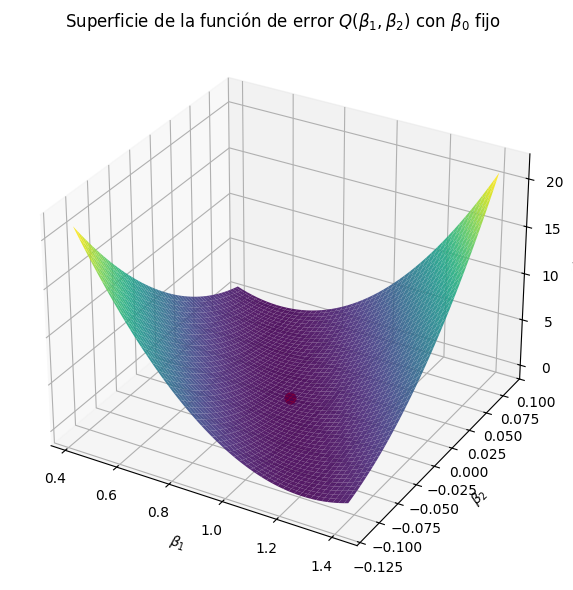

In [61]:
beta_hat = beta
beta0_fijo = beta_hat[0]

b1_vals = np.linspace(beta_hat[1] - 0.5, beta_hat[1] + 0.5, 200)
b2_vals = np.linspace(beta_hat[2] - 0.1, beta_hat[2] + 0.1, 200)

B1, B2 = np.meshgrid(b1_vals, b2_vals)
Q_vals = np.zeros_like(B1)

for i in range(B1.shape[0]):
    for j in range(B1.shape[1]):
        beta_tmp = np.array([beta0_fijo, B1[i, j], B2[i, j]])
        resid = A @ beta_tmp - y
        Q_vals[i, j] = resid @ resid

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(B1, B2, Q_vals, cmap="viridis", alpha=0.9)

resid_min = A @ beta_hat - y
Q_min = resid_min @ resid_min
ax.scatter(beta_hat[1], beta_hat[2], Q_min, color="red", s=60)

ax.set_xlabel(r"$\beta_1$")
ax.set_ylabel(r"$\beta_2$")
ax.set_zlabel(r"$Q(\beta)$")
ax.set_title(r"Superficie de la función de error $Q(\beta_1,\beta_2)$ con $\beta_0$ fijo")

plt.tight_layout()
plt.show()


## b) Convexidad de \(Q(\beta)\) y mínimo de mínimos cuadrados

Analizamos el gradiente y la Hessiana:

$$
\nabla Q(\beta) = 2A^T(A\beta - y), \qquad
\nabla^2 Q(\beta) = 2A^T A,
$$

para justificar que el punto crítico es el mínimo global del problema.

In [62]:
H = 2 * (A.T @ A)
eigvals = np.linalg.eigvals(H)

grad_beta_hat = 2 * A.T @ (A @ beta_hat - y)

eigvals, grad_beta_hat


(array([770.00954402,   6.94297451,   1.04748147]),
 array([-4.88498131e-15, -5.32907052e-15,  3.90798505e-14]))

## 4. Optimización numérica: descenso por gradiente

Implementamos el algoritmo de descenso por gradiente para minimizar la función de error,
evaluando su comportamiento según distintas tasas de aprendizaje.

## a) Implementación del método

Aplicamos el esquema iterativo

$$
\beta^{(k+1)} = \beta^{(k)} - \eta\, \nabla Q(\beta^{(k)}),
$$

partiendo de un valor inicial y registrando el progreso del algoritmo.

In [63]:
def gradient_descent_Q(A, y, beta0, lr=1e-3, tol=1e-8, max_iter=100000):
    beta = beta0.astype(float).copy()
    grad_norm_history = []

    for k in range(max_iter):
        grad = 2 * A.T @ (A @ beta - y)
        grad_norm = np.linalg.norm(grad)
        grad_norm_history.append(grad_norm)

        if grad_norm < tol:
            break

        beta = beta - lr * grad

    return beta, np.array(grad_norm_history), k + 1


## b) Experimentos con tasas de aprendizaje y tolerancias

Probamos distintos valores de \(\eta\) y de tolerancia para estudiar estabilidad,
velocidad de convergencia y precisión del método.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2791: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
/var/folders/w2/ddmn21_s0j5g5k_ptkssbfp40000gn/T/ipykernel_12069/2082454062.py:6: RuntimeWarning: overflow encountered in matmul
  grad = 2 * A.T @ (A @ beta - y)
/var/folders/w2/ddmn21_s0j5g5k_ptkssbfp40000gn/T/ipykernel_12069/2082454062.py:6: RuntimeWarning: invalid value encountered in matmul
  grad = 2 * A.T @ (A @ beta - y)


lr		 tol		 iters	 grad_final		 ||beta_gd - beta_hat||
1e-04	 1e-04	  65028	 9.999e-05	 9.546e-05
1e-04	 1e-06	 100000	 2.564e-06	 2.448e-06
1e-04	 1e-08	 100000	 2.564e-06	 2.448e-06
1e-03	 1e-04	   6501	 9.995e-05	 9.542e-05
1e-03	 1e-06	  10895	 9.997e-07	 9.543e-07
1e-03	 1e-08	  15289	 9.998e-09	 9.545e-09
5e-03	 1e-04	 100000	 nan	 nan
5e-03	 1e-06	 100000	 nan	 nan
5e-03	 1e-08	 100000	 nan	 nan
1e-02	 1e-04	 100000	 nan	 nan
1e-02	 1e-06	 100000	 nan	 nan
1e-02	 1e-08	 100000	 nan	 nan


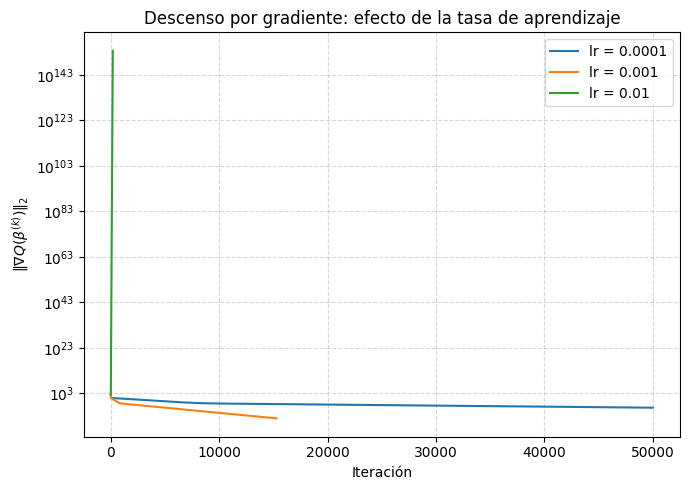

In [64]:
lrs = [1e-4, 1e-3, 5e-3, 1e-2]
tols = [1e-4, 1e-6, 1e-8]

resultados = []

for lr in lrs:
    for tol in tols:
        beta0 = np.zeros_like(beta_hat)
        beta_gd, grad_hist, iters = gradient_descent_Q(
            A, y, beta0,
            lr=lr,
            tol=tol,
            max_iter=100000
        )
        dist = np.linalg.norm(beta_gd - beta_hat)
        grad_final = grad_hist[-1]
        resultados.append((lr, tol, iters, grad_final, dist))

print("lr\t\t tol\t\t iters\t grad_final\t\t ||beta_gd - beta_hat||")
for lr, tol, iters, grad_final, dist in resultados:
    print(f"{lr:.0e}\t {tol:.0e}\t {iters:6d}\t {grad_final:.3e}\t {dist:.3e}")

plt.figure(figsize=(7,5))
for lr in [1e-4, 1e-3, 1e-2]:
    beta0 = np.zeros_like(beta_hat)
    beta_gd, grad_hist, iters = gradient_descent_Q(
        A, y, beta0,
        lr=lr,
        tol=1e-8,
        max_iter=50000
    )
    plt.semilogy(grad_hist, label=f"lr = {lr}")

plt.xlabel("Iteración")
plt.ylabel(r"$\|\nabla Q(\beta^{(k)})\|_2$")
plt.title("Descenso por gradiente: efecto de la tasa de aprendizaje")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 5. Discusión y extensiones

Comparamos los distintos métodos (ecuaciones normales, SVD y gradiente) y analizamos
cómo se modifica el ajuste al agregar complejidad al modelo o ruido en los datos.

## a) Relación entre los diferentes métodos

Se discuten similitudes y diferencias entre ecuaciones normales, SVD y descenso por gradiente,
tanto en estabilidad numérica como en interpretación.

## b) Modelo cúbico y efecto del ruido

Extendemos el modelo agregando un término cúbico y evaluamos cómo cambia el ajuste
cuando se introduce ruido en los datos.

In [65]:
x = np.array([0, 1, 2, 3, 4], dtype=float)
y = np.array([1, 2, 2.8, 3.6, 4.5], dtype=float)

A_quad = np.vstack([np.ones_like(x), x, x**2]).T
A_cubic = np.vstack([np.ones_like(x), x, x**2, x**3]).T

ATA_quad = A_quad.T @ A_quad
ATy_quad = A_quad.T @ y
ATA_cubic = A_cubic.T @ A_cubic
ATy_cubic = A_cubic.T @ y

beta_quad = gaussian_elimination_solve(ATA_quad, ATy_quad)
beta_cubic = gaussian_elimination_solve(ATA_cubic, ATy_cubic)

x_plot = np.linspace(x.min()-0.5, x.max()+0.5, 200)
y_hat_quad = beta_quad[0] + beta_quad[1]*x_plot + beta_quad[2]*x_plot**2
y_hat_cubic = (beta_cubic[0]
               + beta_cubic[1]*x_plot
               + beta_cubic[2]*x_plot**2
               + beta_cubic[3]*x_plot**3)

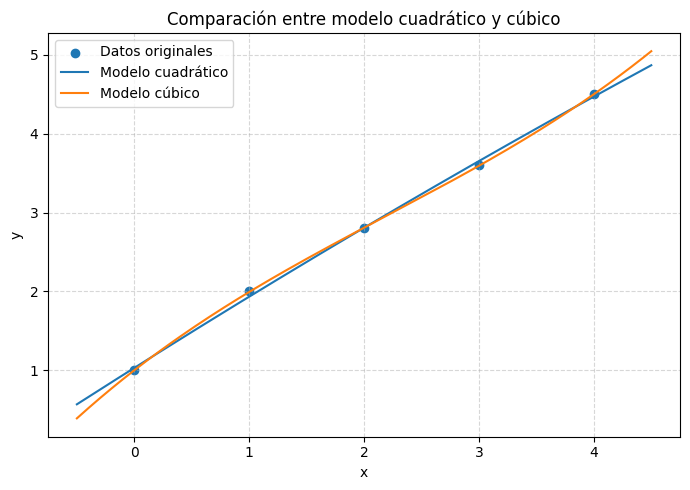

In [66]:

plt.figure(figsize=(7,5))
plt.scatter(x, y, label="Datos originales")
plt.plot(x_plot, y_hat_quad, label="Modelo cuadrático")
plt.plot(x_plot, y_hat_cubic, label="Modelo cúbico")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparación entre modelo cuadrático y cúbico")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [67]:
rng = np.random.default_rng(0)
noise = rng.normal(loc=0.0, scale=0.1, size=x.shape)
y_noisy = y + noise

ATy_quad_noisy = A_quad.T @ y_noisy
beta_quad_noisy = gaussian_elimination_solve(ATA_quad, ATy_quad_noisy)

y_hat_quad_clean = A_quad @ beta_quad
y_hat_quad_noisy = A_quad @ beta_quad_noisy

mse_clean = np.mean((y - y_hat_quad_clean)**2)
mse_noisy = np.mean((y_noisy - y_hat_quad_noisy)**2)

mse_clean, mse_noisy

(np.float64(0.0018285714285714183), np.float64(0.0008798764750914796))

## 6. Aplicación a un caso real

Aplicamos los métodos estudiados a un dataset real de salarios para construir un modelo predictivo
basado en los años de experiencia.

## a) Cargar el dataset

Importamos los datos, exploramos sus columnas y seleccionamos las variables relevantes
para el modelo lineal.

In [68]:

df = pd.read_csv("Salary Data.csv")
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


## b) Construcción de la matriz de diseño

Elegimos como variable objetivo el salario y como predictor los años de experiencia,
armando la matriz de diseño correspondiente al modelo lineal.

In [69]:
cols = ["Years of Experience", "Salary"]
df_num = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

X = df_num[["Years of Experience"]].to_numpy()
y = df_num["Salary"].to_numpy()

A = np.hstack([np.ones((X.shape[0], 1)), X])
A.shape, y.shape

((373, 2), (373,))

## c) Resolver el modelo por ecuaciones normales

Calculamos los coeficientes ajustando el modelo lineal mediante:

$$
A^T A\,\beta = A^T y.
$$

In [70]:
ATA = A.T @ A
ATy = A.T @ y

beta_norm = gaussian_elimination_solve(ATA, ATy)
beta_norm

array([31921.21691704,  6844.51051448])

## d) Resolver el modelo mediante SVD

Aplicamos la descomposición \(A = U \Sigma V^T\) para obtener la solución alternativa:

$$
\hat\beta_{\text{SVD}} = V \Sigma^{-1} U^T y.
$$

In [71]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)
Sigma_inv = np.diag(1 / S)

beta_svd = Vt.T @ Sigma_inv @ U.T @ y

np.linalg.norm(beta_svd - beta_norm)

np.float64(6.208592154826333e-11)

## e) Evaluación del modelo

Calculamos el error cuadrático medio y analizamos el histograma de residuos para evaluar
la calidad del ajuste obtenido.

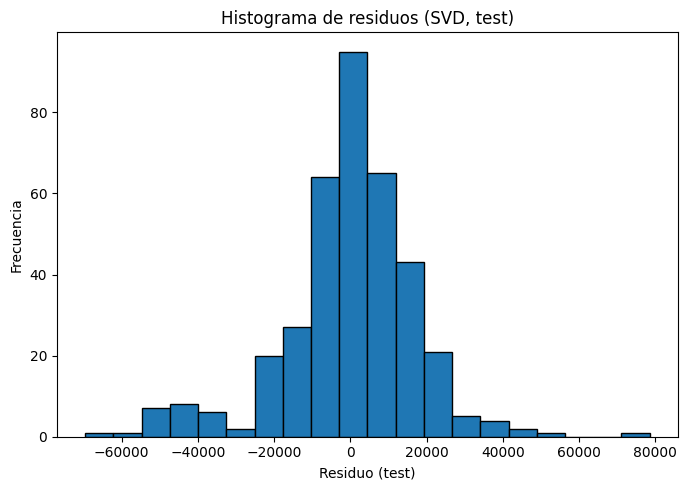

In [72]:
y_hat = A @ beta_norm
mse = np.mean((y - y_hat)**2)

residuos = y - y_hat

plt.figure(figsize=(7,5))
plt.hist(residuos, bins=20, edgecolor="black")
plt.xlabel("Residuo (test)")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos (SVD, test)")
plt.tight_layout()
plt.show()

## f) Visualización del ajuste

Graficamos los salarios reales versus los predichos junto con la recta ajustada,
para observar visualmente el desempeño del modelo lineal.

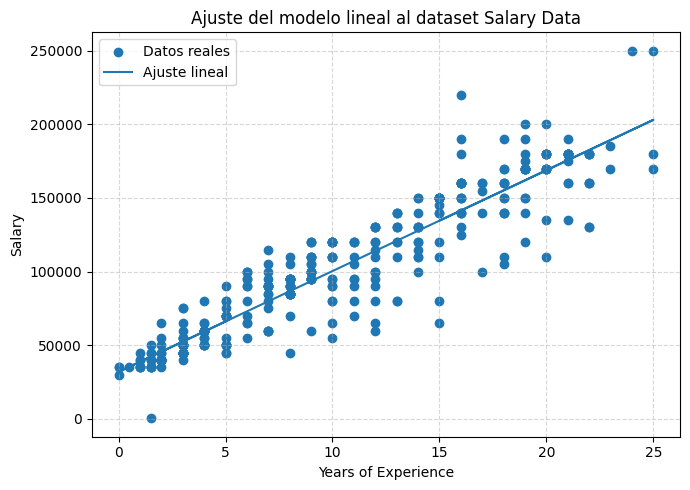

In [73]:

plt.figure(figsize=(7, 5))
plt.scatter(X, y, label="Datos reales")
plt.plot(X, y_hat, label="Ajuste lineal")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.title("Ajuste del modelo lineal al dataset Salary Data")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()